In [1]:
import sys

sys.path.insert(0, '../../PSC')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from PSC.data import random_point, stiefel_point_cloud
from PSC.initialization import tube_det, tube_rank, ransac
from PSC.projections import PCA, manopt_alpha

In [4]:
N = 1000
n = 100
k = 5

s = 1000

p_true = 0.98

inlier = stiefel_point_cloud(N,n,k,int(s*p_true),0.02)
outlier = stiefel_point_cloud(N,n,k,s-int(s*p_true),0.01)

ys = np.concatenate((outlier['ys'], inlier['ys']))

In [5]:
ys_new = ransac(ys, n, p_true, verbose=True)
print(len(ys_new))

20 [ 7  6  5  8  0 11 18  1  9 10 17 15  2 13 16 19 12  4  3 14]
0 []
980


In [6]:
%timeit ransac(ys, n, p_true)

6.77 s ± 1.25 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Test removing points that don't meet the rank condition

In [7]:
s = [10, 50, 100, 500, 1000]
N = [10, 50, 100, 500, 1000]

In [8]:
t1 = np.zeros((len(s), len(N), 5))
t2 = np.zeros_like(t1)
t3 = np.zeros((len(s), len(N), 3))

for i, s_i in enumerate(s):
    for j, N_j in enumerate(N):
        n = int(0.2*N_j)
        k = int(0.1*N_j)

        alpha_init = random_point(N_j, n)
        
        ys = stiefel_point_cloud(N_j,n,k,s_i,0.01, alpha=alpha_init)['points']
        print(ys.shape)
        
        alpha = PCA(ys, n)

        res = %timeit -o -r 5 tube_det(ys, alpha)
        t1[i, j, :] = res.timings

        res = %timeit -o -r 5 tube_rank(ys, alpha)
        t2[i, j, :] = res.timings

        res = %timeit -o -r 3 manopt_alpha(ys, alpha, verbosity=0)
        t3[i, j, :] = res.timings

np.savez('runtime.npz', det=t1, rank=t2, psc=t3)

(10, 10, 1)
9.07 μs ± 29.6 ns per loop (mean ± std. dev. of 5 runs, 100,000 loops each)
13 μs ± 80.2 ns per loop (mean ± std. dev. of 5 runs, 100,000 loops each)
1.57 ms ± 8.78 μs per loop (mean ± std. dev. of 3 runs, 1,000 loops each)
(10, 50, 5)
72.3 μs ± 594 ns per loop (mean ± std. dev. of 5 runs, 10,000 loops each)
50.5 μs ± 75.1 ns per loop (mean ± std. dev. of 5 runs, 10,000 loops each)
6.29 ms ± 44.9 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)
(10, 100, 10)
391 μs ± 2.07 μs per loop (mean ± std. dev. of 5 runs, 1,000 loops each)
224 μs ± 3.06 μs per loop (mean ± std. dev. of 5 runs, 1,000 loops each)
21.7 ms ± 154 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)
(10, 500, 50)
16 ms ± 973 μs per loop (mean ± std. dev. of 5 runs, 100 loops each)
6.97 ms ± 537 μs per loop (mean ± std. dev. of 5 runs, 100 loops each)
1.89 s ± 34.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
(10, 1000, 100)
56.2 ms ± 2.21 ms per loop (mean ± std. dev. of 5 runs, 10 loop

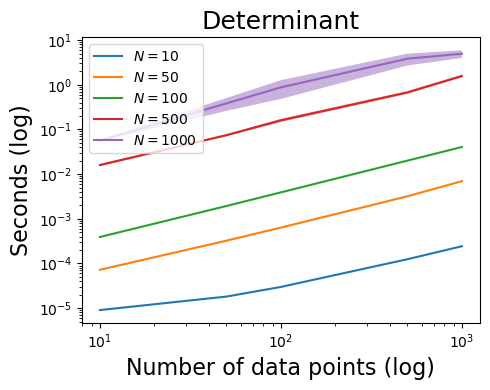

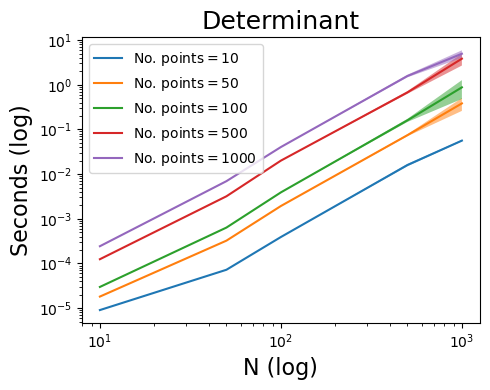

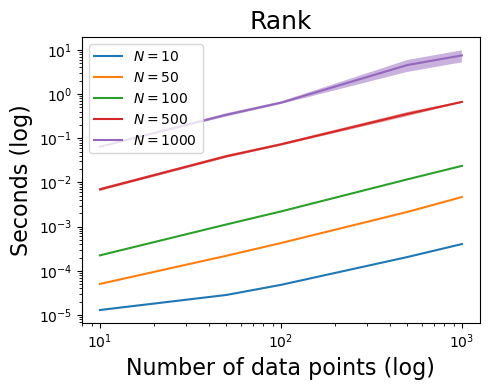

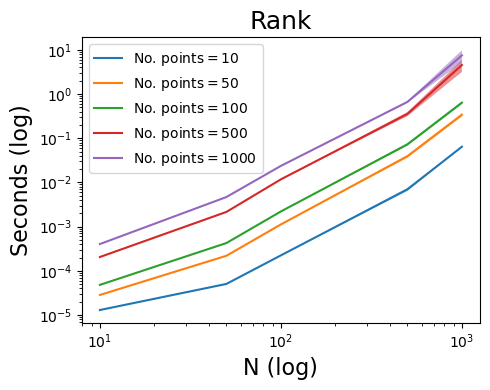

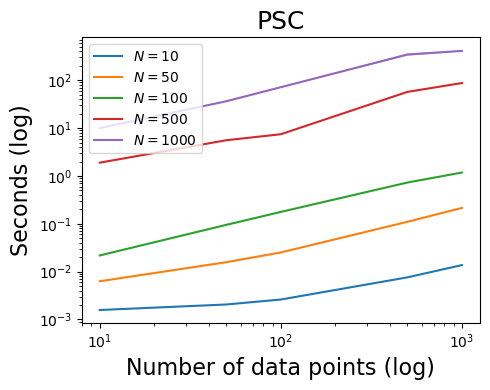

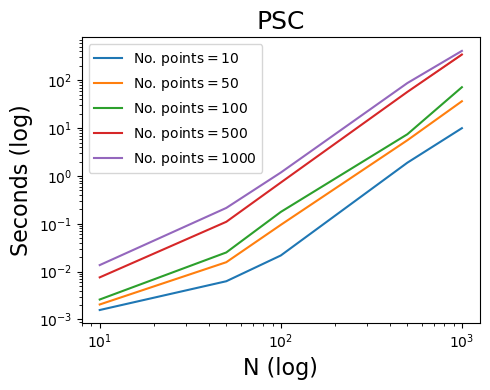

In [9]:
for label, t in zip(['Determinant', 'Rank', 'PSC'], [t1, t2, t3]):
    mean_t = t.mean(axis=-1)
    std_t = t.std(axis=-1)
    
    fig, ax = plt.subplots(1, figsize=(5,4))
    for j in range(len(N)):
        plt.plot(s, mean_t[:, j], label=f'$N={N[j]}$')
        plt.fill_between(s, mean_t[:, j]-std_t[:, j], mean_t[:, j]+std_t[:, j], alpha=0.5)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of data points (log)', fontsize=16)
    plt.ylabel('Seconds (log)', fontsize=16)
    plt.title(label, fontsize=18)
    plt.legend()
    plt.tight_layout()
    plt.savefig(label+'-s.pdf', dpi=300)
    plt.show()
    
    fig, ax = plt.subplots(1, figsize=(5,4))
    for i in range(len(s)):
        plt.plot(N, mean_t[i, :], label=f'No. points$={s[i]}$')
        plt.fill_between(N, mean_t[i, :]-std_t[i, :], mean_t[i, :]+std_t[i, :], alpha=0.5)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('N (log)', fontsize=16)
    plt.ylabel('Seconds (log)', fontsize=16)
    plt.title(label, fontsize=18)
    plt.legend()
    plt.tight_layout()
    plt.savefig(label+'-N.pdf', dpi=300)
    plt.show()

# Test RANSAC

In [10]:
s = 1000
N = 200
n = 50
k = 5

p_true = 0.98

ys_inliers = stiefel_point_cloud(N,n,k,int(p_true*s),0.01)['points']
ys_outliers = stiefel_point_cloud(N,n,k,s-int(p_true*s),0.01)['points']
ys = np.concatenate((ys_inliers,ys_outliers), axis=0)

print(ys.shape)

ys_new = ransac(ys, n, p = 0.99, tau = 3, verbose=True)
print(len(ys_new))

(1000, 200, 5)
19 [990 991 994 984 997 993 985 999 982 981 980 987 988 998 995 983 986 989
 996]
1 [992]
2 [286 816]
0 []
978


In [11]:
%timeit ransac(ys, n, p = 0.99, tau = 3, verbose=False)

808 ms ± 108 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 1.0, 'Checking Ranks')

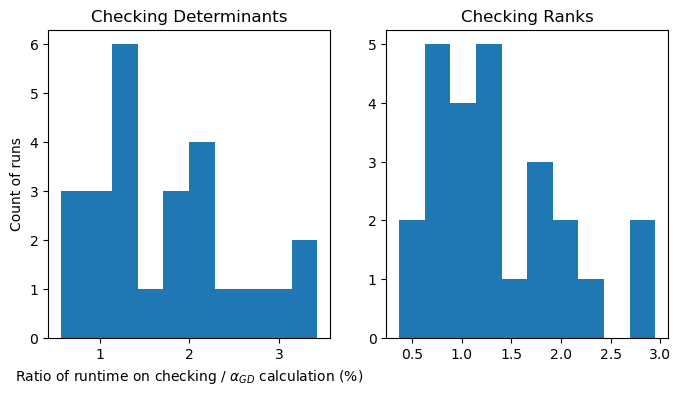

In [30]:
t1_mean = t1.mean(axis=-1)
t2_mean = t2.mean(axis=-1)
t3_mean = t3.mean(axis=-1)

fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].hist((t1_mean/t3_mean).ravel()*100)
ax[0].set_xlabel(r'Ratio of runtime on checking / $\alpha_{GD}$ calculation (%)')
ax[0].set_title('Checking Determinants')
ax[0].set_ylabel('Count of runs')

ax[1].hist((t2_mean/t3_mean).ravel()*100)
ax[1].set_title('Checking Ranks')

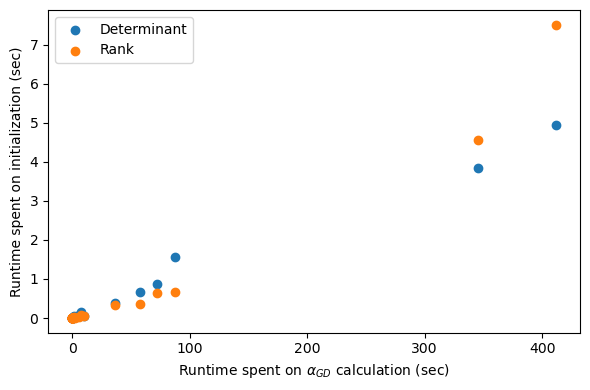

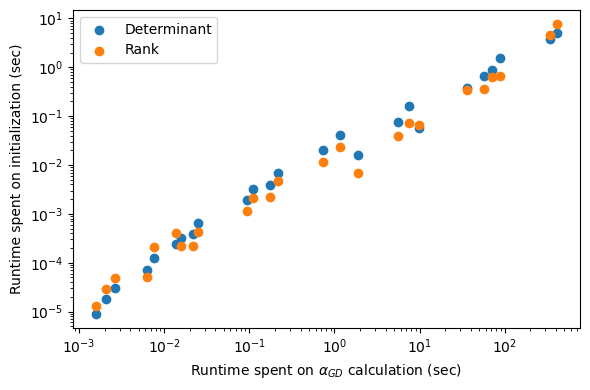

In [40]:
t1_mean = t1.mean(axis=-1).ravel()
t2_mean = t2.mean(axis=-1).ravel()
t3_mean = t3.mean(axis=-1).ravel()

fig, ax = plt.subplots(1, figsize=(6,4))
plt.scatter(t3_mean, t1_mean, label='Determinant')
plt.scatter(t3_mean, t2_mean, label='Rank')
plt.xlabel(r'Runtime spent on $\alpha_{GD}$ calculation (sec)')
plt.ylabel(r'Runtime spent on initialization (sec)')
plt.legend()
plt.tight_layout()
plt.savefig('runtime.pdf')
plt.show()


fig, ax = plt.subplots(1, figsize=(6,4))
plt.scatter(t3_mean, t1_mean, label='Determinant')
plt.scatter(t3_mean, t2_mean, label='Rank')
plt.xlabel(r'Runtime spent on $\alpha_{GD}$ calculation (sec)')
plt.ylabel(r'Runtime spent on initialization (sec)')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig('log-runtime.pdf')
plt.show()

(array([2., 5., 4., 5., 1., 3., 2., 1., 0., 2.]),
 array([0.36819677, 0.62641104, 0.8846253 , 1.14283957, 1.40105383,
        1.6592681 , 1.91748237, 2.17569663, 2.4339109 , 2.69212516,
        2.95033943]),
 <BarContainer object of 10 artists>)

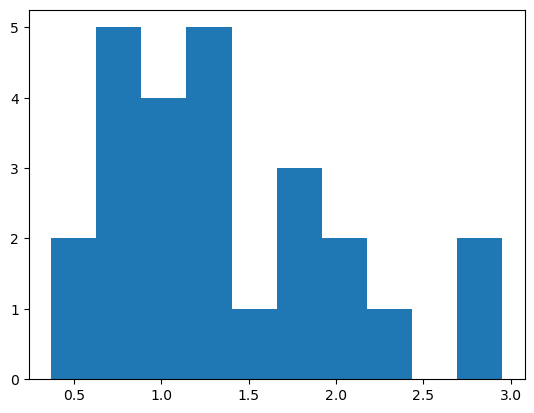

In [19]:
plt.hist((t2.mean(axis=-1)/t3.mean(axis=-1)).ravel()*100)